# SemEval-2017 Task 4: Sentiment Analysis in Twitter arabic


In [1]:
import os
import random
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.cm as cm
from matplotlib import rcParams
from prettytable import PrettyTable
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.isri import ISRIStemmer
from collections import Counter 
import itertools
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from joblib import dump, load

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Get data**

In [2]:
# get data 
import pandas as pd

df = pd.read_table('../input/semevalll/SemEval2017-train.txt' , usecols=[1,2], encoding='utf-8', names=['sentiment', 'tweet'])
dataTest = pd.read_table('../input/semevalll/SemEval2017-test.txt', usecols=[1,2], encoding='utf-8', names=['sentiment', 'tweet'])                   
#combine = [dataTrain,dataTest]
df

,sentiment,tweet
0,positive,إجبار أبل على التعاون على فك شفرة اجهزتها http...
1,positive,RT @20fourMedia: #غوغل تتحدى أبل وأمازون بأجهز...
2,positive,جوجل تنافس أبل وسامسونج بهاتف جديد https://t.c...
3,positive,رئيس شركة أبل: الواقع المعزز سيصبح أهم من الطع...
4,neutral,ساعة أبل في الأسواق مرة أخرى https://t.co/dY2x...
...,...,...
3348,positive,طريقة تعطيل اي زر في لوحة المفاتيح على نظام وي...
3349,neutral,RT @syst__em: إطلاق تحديث تراكمي برقم 14393.32...
3350,neutral,4 طرق لحذف الملفات المستعصية من الحذف في ويندو...
3351,neutral,شرح فيديو مهم جدا حل لمشاكل الكومبيوتر كيف تقو...


# **Processing**

# search and remove missing values

In [3]:
print(np.sum(df.isnull().any(axis=1)))

clean_df = df.dropna()
print(np.sum(clean_df.isnull().any(axis=1)))

0
0


In [4]:
print (df.notnull().any(axis = 0))


sentiment    True
tweet        True
dtype: bool


# Remove hashtag

In [5]:
def remove_hashtag(df, col = 'tweet'):
    for letter in r'#.][!XR':
        df[col] = df[col].astype(str).str.replace(letter,'', regex=True)
    

        
remove_hashtag(clean_df)
clean_df

,sentiment,tweet
0,positive,إجبار أبل على التعاون على فك شفرة اجهزتها http...
1,positive,T @20fourMedia: غوغل تتحدى أبل وأمازون بأجهزة ...
2,positive,جوجل تنافس أبل وسامسونج بهاتف جديد https://tco...
3,positive,رئيس شركة أبل: الواقع المعزز سيصبح أهم من الطع...
4,neutral,ساعة أبل في الأسواق مرة أخرى https://tco/dY2xO...
...,...,...
3348,positive,طريقة تعطيل اي زر في لوحة المفاتيح على نظام وي...
3349,neutral,T @syst__em: إطلاق تحديث تراكمي برقم 14393321 ...
3350,neutral,4 طرق لحذف الملفات المستعصية من الحذف في ويندو...
3351,neutral,شرح فيديو مهم جدا حل لمشاكل الكومبيوتر كيف تقو...


# Remove Punctuations

In [6]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

# Normalization

In [7]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

# Remove Repeating Char

In [8]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

# Processing Labels

In [9]:
def procesSentiment(Sentiment):
    Sentiment = re.sub("positive", "1", Sentiment)
    Sentiment = re.sub("negative", "-1", Sentiment)
    Sentiment = re.sub("neutral", "0", Sentiment)
    return Sentiment
        

In [10]:
def processDocument(doc, stemmer): 

    #Replace @username with empty string
    doc = re.sub(r'@[^\s]+', ' ', doc)
    doc = re.sub(r'_', ' ', doc)
    doc = re.sub(r'\n', ' ', doc)
    doc = re.sub(r'[a-z,A-Z]', '', doc)
    doc = re.sub(r'\d', '', doc)
    #Convert www.* or https?://* to " "
    doc = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',doc)
    #Replace #word with word
    doc = re.sub(r'#([^\s]+)', r'\1', doc)
    # remove punctuations
    doc= remove_punctuations(doc)
    # normalize the tweet
    doc= normalize_arabic(doc)
    # remove repeated letters
    doc=remove_repeating_char(doc)
    #stemming
    doc = stemmer.stem(doc)
   
    return doc



stemmer = ISRIStemmer()
clean_df["tweet"] = clean_df['tweet'].apply(lambda x: processDocument(x, stemmer))
clean_df["sentiment"] =clean_df['sentiment'].apply(lambda x: procesSentiment(x))
clean_df["sentiment"]
clean_df

,sentiment,tweet
0,1,اجبار ابل علي التعاون علي فك شفره اجهزتها
1,1,غوغل تحدي ابل وامازون باجهزه جديده
2,1,جوجل تنافس ابل وسامسونج بهاتف جديد
3,1,رئيس شركه ابل الواقع المعز سيصبح اهم من الطعام
4,0,ساعه ابل في الاسواق مره اخري
...,...,...
3348,1,طريقه تعطيل اي زر في لوحه المفاتيح علي نظام وي...
3349,0,اطلاق تحديث تراكمي برقم ل ويندوز المكتبي واله...
3350,0,طرق لحذف الملفات المستعصيه من الحذف في ويندوز...
3351,0,شرح فيديو مهم جدا حل لمشاكل الكومبيوتر كيف تقو...


In [11]:
tokenizer = RegexpTokenizer(r'\w+')
clean_df["tweet"] = clean_df["tweet"].apply(tokenizer.tokenize)
# print(clean_df['text'].values[0])
clean_df

,sentiment,tweet
0,1,"[اجبار, ابل, علي, التعاون, علي, فك, شفره, اجهز..."
1,1,"[غوغل, تحدي, ابل, وامازون, باجهزه, جديده]"
2,1,"[جوجل, تنافس, ابل, وسامسونج, بهاتف, جديد]"
3,1,"[رئيس, شركه, ابل, الواقع, المعز, سيصبح, اهم, م..."
4,0,"[ساعه, ابل, في, الاسواق, مره, اخري]"
...,...,...
3348,1,"[طريقه, تعطيل, اي, زر, في, لوحه, المفاتيح, علي..."
3349,0,"[اطلاق, تحديث, تراكمي, برقم, ل, ويندوز, المكتب..."
3350,0,"[طرق, لحذف, الملفات, المستعصيه, من, الحذف, في,..."
3351,0,"[شرح, فيديو, مهم, جدا, حل, لمشاكل, الكومبيوتر,..."


# Remove Stop Words

In [12]:
stopwords_list = stopwords.words('arabic')
listToStr = ' '.join([str(elem) for elem in stopwords_list]) 
print(listToStr)

إذ إذا إذما إذن أف أقل أكثر ألا إلا التي الذي الذين اللاتي اللائي اللتان اللتيا اللتين اللذان اللذين اللواتي إلى إليك إليكم إليكما إليكن أم أما أما إما أن إن إنا أنا أنت أنتم أنتما أنتن إنما إنه أنى أنى آه آها أو أولاء أولئك أوه آي أي أيها إي أين أين أينما إيه بخ بس بعد بعض بك بكم بكم بكما بكن بل بلى بما بماذا بمن بنا به بها بهم بهما بهن بي بين بيد تلك تلكم تلكما ته تي تين تينك ثم ثمة حاشا حبذا حتى حيث حيثما حين خلا دون ذا ذات ذاك ذان ذانك ذلك ذلكم ذلكما ذلكن ذه ذو ذوا ذواتا ذواتي ذي ذين ذينك ريث سوف سوى شتان عدا عسى عل على عليك عليه عما عن عند غير فإذا فإن فلا فمن في فيم فيما فيه فيها قد كأن كأنما كأي كأين كذا كذلك كل كلا كلاهما كلتا كلما كليكما كليهما كم كم كما كي كيت كيف كيفما لا لاسيما لدى لست لستم لستما لستن لسن لسنا لعل لك لكم لكما لكن لكنما لكي لكيلا لم لما لن لنا له لها لهم لهما لهن لو لولا لوما لي لئن ليت ليس ليسا ليست ليستا ليسوا ما ماذا متى مذ مع مما ممن من منه منها منذ مه مهما نحن نحو نعم ها هاتان هاته هاتي هاتين هاك هاهنا هذا هذان هذه هذي هذين هكذا هل هلا هم هما هن هنا هنا

In [13]:
clean_df["tweet"] = clean_df["tweet"].apply(lambda x: [item for item in x if item not in stopwords_list])
clean_df

,sentiment,tweet
0,1,"[اجبار, ابل, علي, التعاون, علي, فك, شفره, اجهز..."
1,1,"[غوغل, تحدي, ابل, وامازون, باجهزه, جديده]"
2,1,"[جوجل, تنافس, ابل, وسامسونج, بهاتف, جديد]"
3,1,"[رئيس, شركه, ابل, الواقع, المعز, سيصبح, اهم, ا..."
4,0,"[ساعه, ابل, الاسواق, مره, اخري]"
...,...,...
3348,1,"[طريقه, تعطيل, اي, زر, لوحه, المفاتيح, علي, نظ..."
3349,0,"[اطلاق, تحديث, تراكمي, برقم, ل, ويندوز, المكتب..."
3350,0,"[طرق, لحذف, الملفات, المستعصيه, الحذف, ويندوز,..."
3351,0,"[شرح, فيديو, مهم, جدا, حل, لمشاكل, الكومبيوتر,..."


# Count Propetries

In [14]:
def countPropetries(df):
    all_words = [word for tokens in df["tweet"] for word in tokens]
    sentence_lengths = [len(tokens) for tokens in df["tweet"]]

    VOCAB = sorted(list(set(all_words)))

    print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
    print("Max sentence length is %s" % max(sentence_lengths))
    return all_words

In [15]:
positive_df = clean_df.loc[clean_df["sentiment"] == '1']
neutral_df = clean_df.loc[clean_df["sentiment"] == '0']
negative_df = clean_df.loc[clean_df["sentiment"] == '-1']

print("positive : ")
positive_words = countPropetries(positive_df)
print("\nneutral : ")
neutral_words = countPropetries(neutral_df)
print("\nnegative : ")
negative_words = countPropetries(negative_df)


positive : 
8312 words total, with a vocabulary size of 4476
Max sentence length is 24

neutral : 
15433 words total, with a vocabulary size of 7407
Max sentence length is 28

negative : 
14765 words total, with a vocabulary size of 7403
Max sentence length is 26


In [16]:
def plot(all_words, title):
    counted_words = Counter(all_words)

    words = []
    counts = []
    for letter, count in counted_words.most_common(25):
        words.append(letter)
        counts.append(count)

    colors = cm.rainbow(np.linspace(0, 1, 10))
    rcParams['figure.figsize'] = 20, 10

    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.barh(words, counts, color=colors)

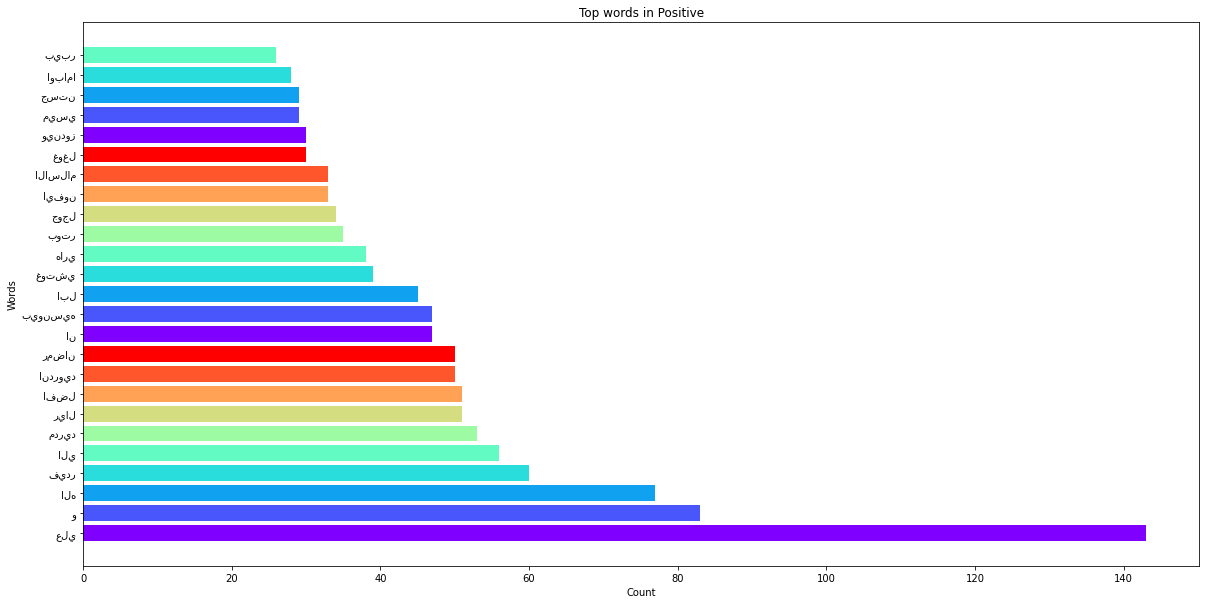

In [17]:
plot(positive_words, 'Top words in Positive')


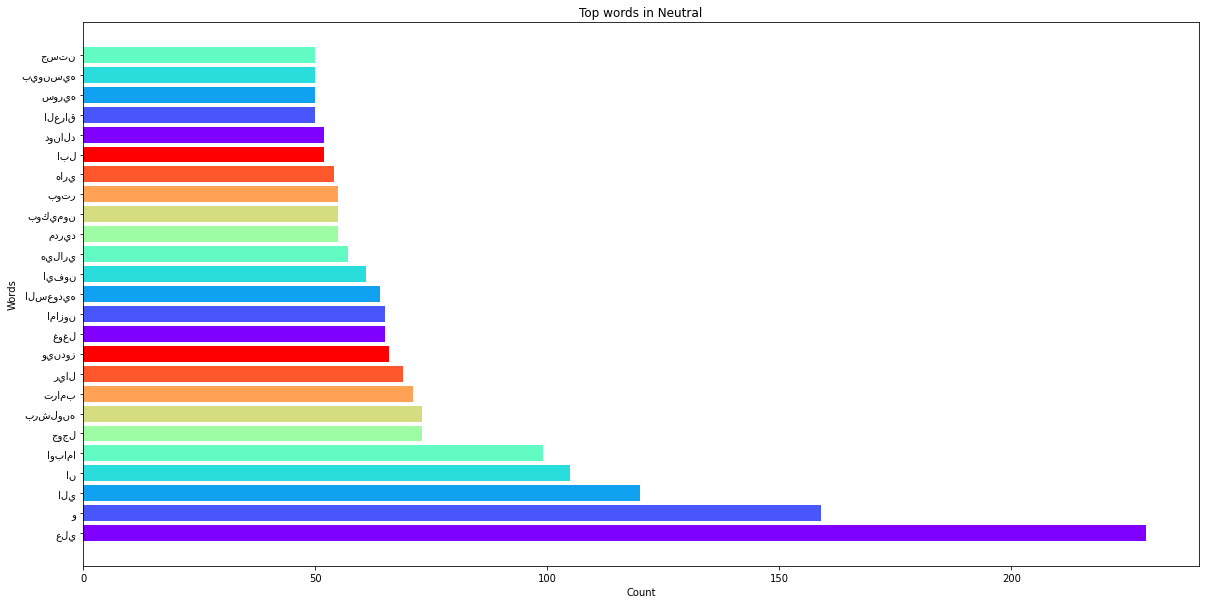

In [18]:
plot(neutral_words, 'Top words in Neutral')


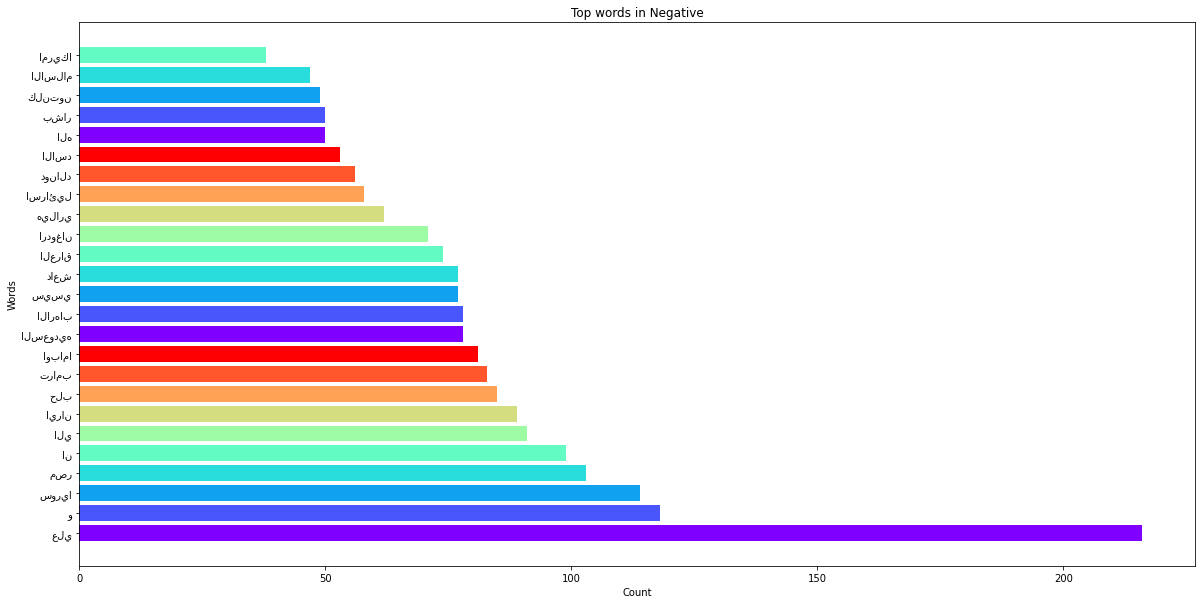

In [19]:
plot(negative_words, 'Top words in Negative')


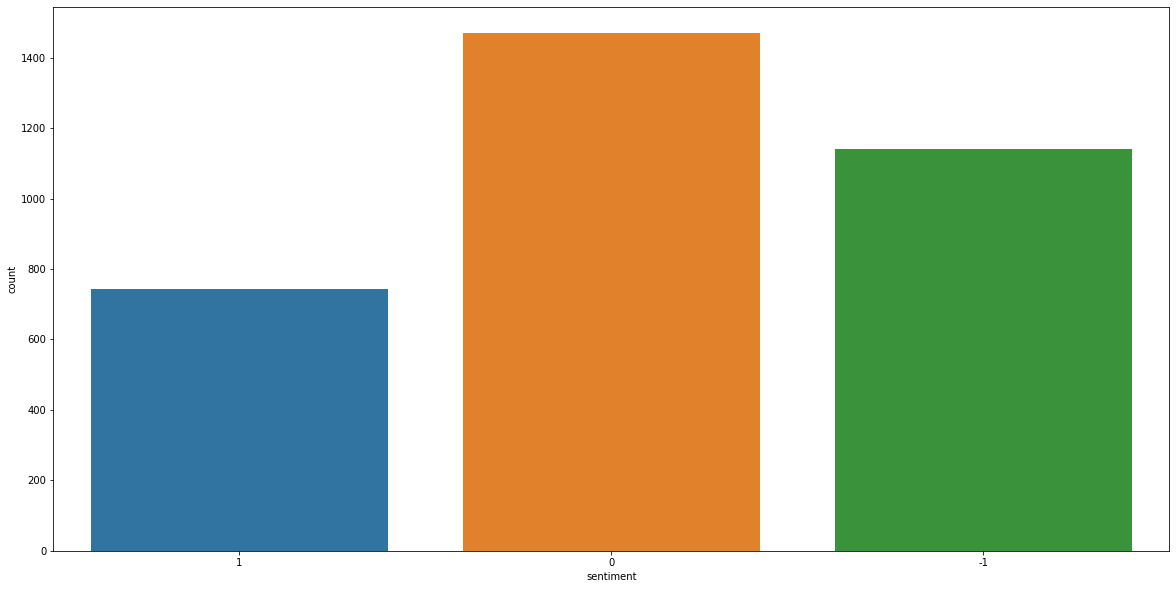

In [20]:
sns.countplot(data= clean_df, x = "sentiment")
plt.show()

# Split Data

In [21]:
y = clean_df['sentiment']
X = clean_df['tweet']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

# Feature Extraction

In [22]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features =10000)

# Fit The Pipeline To The Training Data

In [23]:

model = Pipeline([
                    ("tfidf", word_vectorizer), # convert words to numbers using tfidf
                    ("clf", SVC()) # model the text
])

# Fit the pipeline to the training data
model.fit(X_train.astype('str'), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, strip_accents='unicode',
                                 sublinear_tf=True)),
                ('clf', SVC())])

In [24]:
dump(model, "svm_model.joblib")


['svm_model.joblib']

# Results

In [25]:
def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

y_pred = model.predict(X_test.astype('str'))
result = calculate_results(y_test, y_pred)
result

{'accuracy': 59.475566150178786,
 'precision': 0.638869220026472,
 'recall': 0.5947556615017878,
 'f1': 0.5642415994116097}

# Plot Confusion Matrix

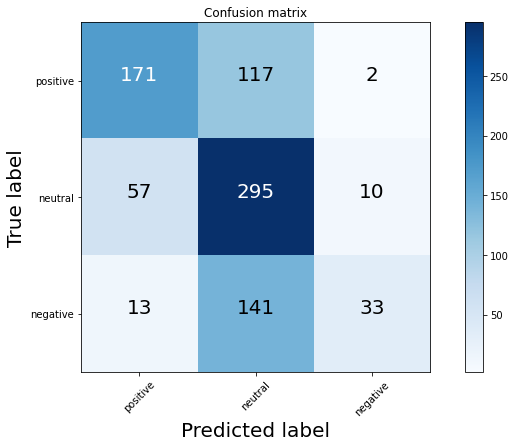

In [26]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure(figsize = (10,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 fontsize=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['positive', 'neutral', 'negative'])

# Testing

In [27]:
df =dataTest
df

,sentiment,tweet
0,positive,@Alito_NBA جواب ذكي 😂
1,neutral,@its_NBA @ssrg90 كلام سليم
2,negative,@nba_155 ياخزياه بس صارخت صراخ وازعجتكم مشكلة ...
3,neutral,@nba_155 صوتي راح اقولك 💔
4,negative,@Alito_NBA انا ماخفت من شي الا ان يكون عقلية م...
...,...,...
6093,neutral,تقول نوال الزغبي : https://t.co/BozQHk3pJU
6094,positive,سيلفي للفنانة 👇الذهبية #نوال_الزغبي @NawalElZo...
6095,positive,فنانة لبنانية كبيرة صوتها إسطوري ؟! #ماجدة_ال...
6096,positive,"@i_7md تذكرني بأغنية نوال الزغبي عينيك كدابين"""""


In [28]:
def prepareData(df):
    remove_hashtag(df, 'tweet')
    df["tweet"] = df['tweet'].apply(lambda x: processDocument(x, stemmer))
    tokenizer = RegexpTokenizer(r'\w+')
    df["tweet"] = df["tweet"].apply(tokenizer.tokenize)
    stopwords_list = stopwords.words('arabic')
    df["tweet"] = df["tweet"].apply(lambda x: [item for item in x if item not in stopwords_list])
    return df

prepared_df = prepareData(df)
prepared_df

,sentiment,tweet
0,positive,"[جواب, ذكي]"
1,neutral,"[كلام, سليم]"
2,negative,"[ياخزياه, صارخت, صراخ, وازعجتكم, مشكله, التوقي..."
3,neutral,"[صوتي, راح, اقولك]"
4,negative,"[انا, ماخفت, شي, الا, ان, يكون, عقليه, مشجعي, ..."
...,...,...
6093,neutral,"[تقول, نوال, الزغبي]"
6094,positive,"[سيلفي, لفنانه, الذهبيه, نوال, الزغبي, باطلاله..."
6095,positive,"[فنانه, لبنانيه, كبيره, صوتها, اسطوري, ماجده, ..."
6096,positive,"[تذكرني, باغنيه, نوال, الزغبي, عينيك, كداب]"


# Loading Model

In [29]:
model = load("./svm_model.joblib")


# Predict

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


[Text(0, 0, '1'), Text(1, 0, '0'), Text(2, 0, '-1')]

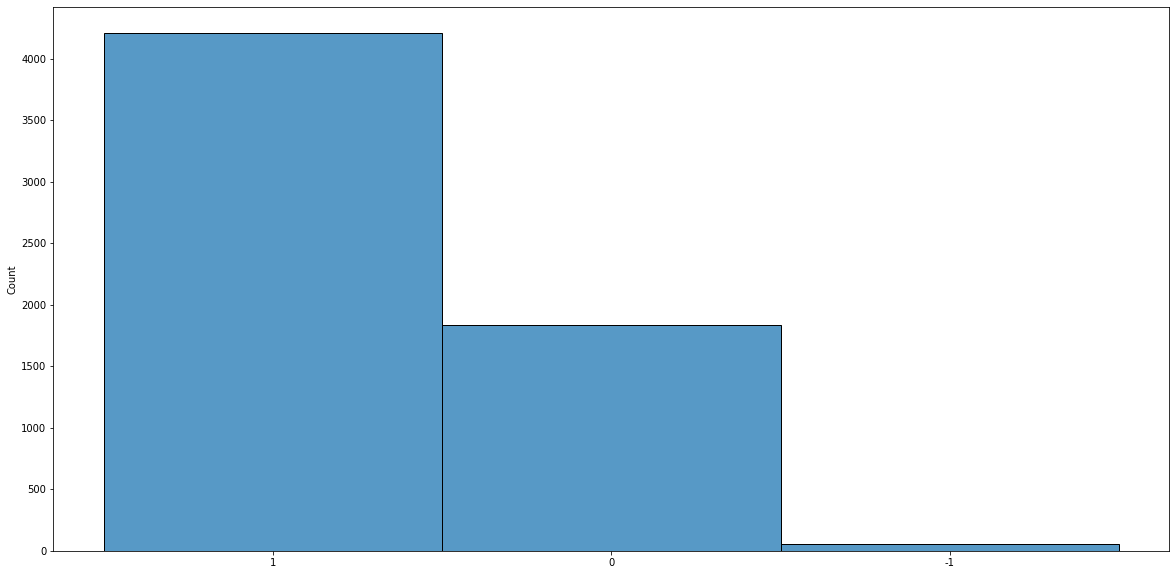

In [30]:
y_pred = model.predict(prepared_df["tweet"].astype('str'))

ax = sns.histplot(y_pred, discrete=True)
ax.set_xticklabels(["1", "0", "-1"])

In [31]:
y_positive = y_pred[y_pred == '1']
y_neutral = y_pred[y_pred == '0']
y_negative = y_pred[y_pred == '-1']


In [32]:
table = {
    "label" : ["1", "0", "-1"],
    "count" : [len(y_positive), len(y_neutral), len(y_negative)],
    "percentage" : [(len(y_positive) / len(y_pred)) * 100,
                    (len(y_neutral) / len(y_pred)) * 100,
                    (len(y_negative) / len(y_pred)) * 100,
                    ]
}

stat = pd.DataFrame(table)
stat


,label,count,percentage
0,1,56,0.918334
1,0,4208,69.006232
2,-1,1834,30.075435


In [33]:
result = [[], [], []]
for i in range(2):
    for index in range(len(y_pred)):
        if y_pred[index] == '1':
            result[0].append(index)
        elif y_pred[index] == '0':
            result[1].append(index)
        elif y_pred[index] == '-1':
            result[2].append(index)
       

# Testing

In [34]:
for i in range(3):
    print(table["label"][i] + " :\n" + str(df.iloc[random.choice(result[i])]["tweet"]) + "\n\n")

1 :
['بنغازيالبيضاءاجتماع', 'مصالحه', 'وتوافق', 'قوتان', 'عكسيتان', 'لحظات', 'ونجحت', 'المصالحهبارك', 'اله', 'الاشخاص', 'وفقوا', 'المتخاصمين']


0 :
['مباراه', 'القادمه', 'كاس', 'العالم', 'لانديه', 'ريال', 'مدريد', 'كلوب', 'امريكا', 'الخميس', 'ديسمبر', 'ظهرا', 'بتوقيت', 'مكه', 'حفيظ', 'ال']


-1 :
['مصر', 'تهزم', 'الولايات', 'المتحده', 'وتاهل', 'لنصف', 'نهائي', 'بطوله', 'العالم', 'لسيدات', 'الاسكواش', 'المقامه', 'باريسالعربيه', 'تويتر', 'تهد', 'بحظر', 'حساب', 'ترامب', 'اذا', 'انتهك', 'قواعد', 'شبكتها', 'الاجتماعيه', 'التحرش', 'المهاجرين', 'الولايات', 'المتحده']




In [35]:
y_pred = model.predict(["حلوه"])
y_pred

array(['1'], dtype=object)